In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pickle
from tqdm import tqdm

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
# import darkhistory
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    os.environ['DH_DIR'] = '/work/submit/yitians/darkhistory/DarkHistory'
    os.environ['DM21CM_DATA_DIR'] = '/data/submit/yitians/DM21cm'
sys.path.append(os.environ['DH_DIR'])
# import DM21cm
sys.path.append('..')

## 1. DM density box

In [3]:
import darkhistory.physics as phys

In [4]:
rs = 30
rho_DM = phys.rho_DM * rs**3 # [eV/cm^3]
print(rho_DM, 'eV/cm^3')

34140204.0 eV/cm^3


In [5]:
from PIL import Image, ImageOps # just for fun, you don't need this

src = 255 - np.array(ImageOps.grayscale(Image.open('plots/source.png').resize((100,100))), dtype=np.float32)
src /= np.mean(src)
src = np.einsum('i,jk->ijk', np.ones((100,)), src)

In [6]:
rho_DM_box = rho_DM * src

## 2. Calculate energy injection

In [7]:
print(phys.inj_rate('swave', rs, mDM=2e6, sigmav=2e-26), 'eV/cm^3/s')

1.1655535291616161e-17 eV/cm^3/s


In [8]:
print(phys.inj_rate('decay', rs, mDM=2e6, lifetime=3e25), 'eV/cm^3/s')

1.1380068e-18 eV/cm^3/s


In [9]:
def inj_rate_box(inj_type, rho_DM_box, mDM=None, sigmav=None, lifetime=None):
    """ Dark matter annihilation/decay energy injection rate box.
    (See darkhistory.physics.inj_rate for original.)

    Parameters
    ----------
    inj_type : {'swave', 'decay'}
        Type of injection.
    rho_DM_box : ndarray (3D)
        DM density box at redshift.
    mDM : float, optional
        DM mass in eV.
    sigmav : float, optional
        Annihilation cross section in cm\ :sup:`-3`\ s\ :sup:`-1`\ .
    lifetime : float, optional
        Decay lifetime in s.

    Returns
    -------
    ndarray
        The dE/dV_dt injection rate box in eV cm\ :sup:`-3`\ s\ :sup:`-1`\ .

    """
    if inj_type == 'swave':
        return rho_DM_box**2 * sigmav / mDM
    elif inj_type == 'decay':
        return rho_DM_box / lifetime
    else:
        raise ValueError('Unknown inj_type.')

In [10]:
z = inj_rate_box('swave', rho_DM_box, mDM=2e6, sigmav=2e-26)

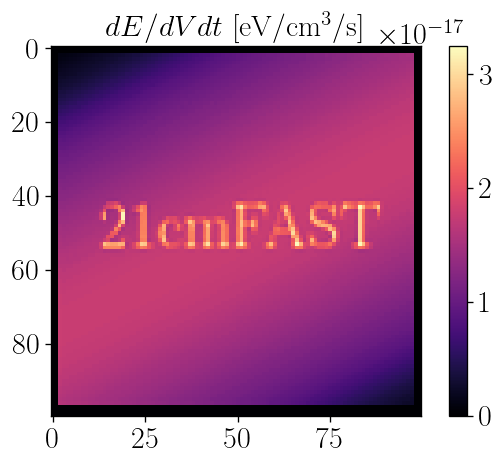

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(z[0], cmap='magma')
ax.set(title=r'$dE/dVdt$ [eV/cm$^3$/s]')
fig.colorbar(im, ax=ax);

## 3. Ionization box

In [12]:
src = np.array(ImageOps.grayscale(Image.open('plots/source2.png')), dtype=np.float32)
src /= 255.
ionization_box = np.einsum('i,jk->ijk', np.ones((100,)), src) # dimension is [1]

## 4. Fractions going into various channels

In [13]:
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools

from dm21cm.common import abscs_nBs_test
abscs = abscs_nBs_test

In [14]:
phot_dep = pickle.load(open(os.environ['DM21CM_DATA_DIR']+'/transferfunctions/nBs_test/phot_dep.interp', 'rb'))


In [15]:
def deposition_f_box(ionization_box, nBs_box, rs, injE, dep_tf):
    
    if ionization_box.shape != nBs_box.shape:
        print(ionization_box.shape, nBs_box.shape)
        raise ValueError('Boxes must have the same shape.')
    shape = ionization_box.shape
    
    out_keys = ['H ion', 'He ion', 'exc', 'heat', 'cont'] # ['H ion', 'He ion', 'exc', 'heat', 'cont']
    f_box_dict = {key: np.zeros(shape) for key in out_keys}
    
    spec = spectools.rebin_N_arr(np.array([1]), np.array([injE]),
                                 out_eng=dep_tf.abscs[dep_tf.io_axes[0]])
    eng_in_bin_spec = spec.eng * spec.N
    toteng = np.sum(eng_in_bin_spec)
    
    for i in range(1):
        for j in range(shape[1]):
            for k in range(shape[2]):
                dep_tf_slice = dep_tf(nBs = nBs_box[i,j,k],
                                      x = ionization_box[i,j,k],
                                      rs = rs)
                dep_arr = np.dot(eng_in_bin_spec, dep_tf_slice.grid_vals)
                dep_dict = { c: dep_arr[i] for i, c in enumerate(dep_tf_slice.out_abscs) }
                for key in out_keys:
                    f_box_dict[key][i,j,k] = dep_dict[key] / toteng
            print(i, j, end='\r')
    return f_box_dict

In [16]:
%%time
nBs_box = rho_DM_box/rho_DM
f_box = deposition_f_box(ionization_box, nBs_box, rs, 450., phot_dep)

CPU times: user 5.63 s, sys: 38.6 ms, total: 5.67 s
Wall time: 5.66 s


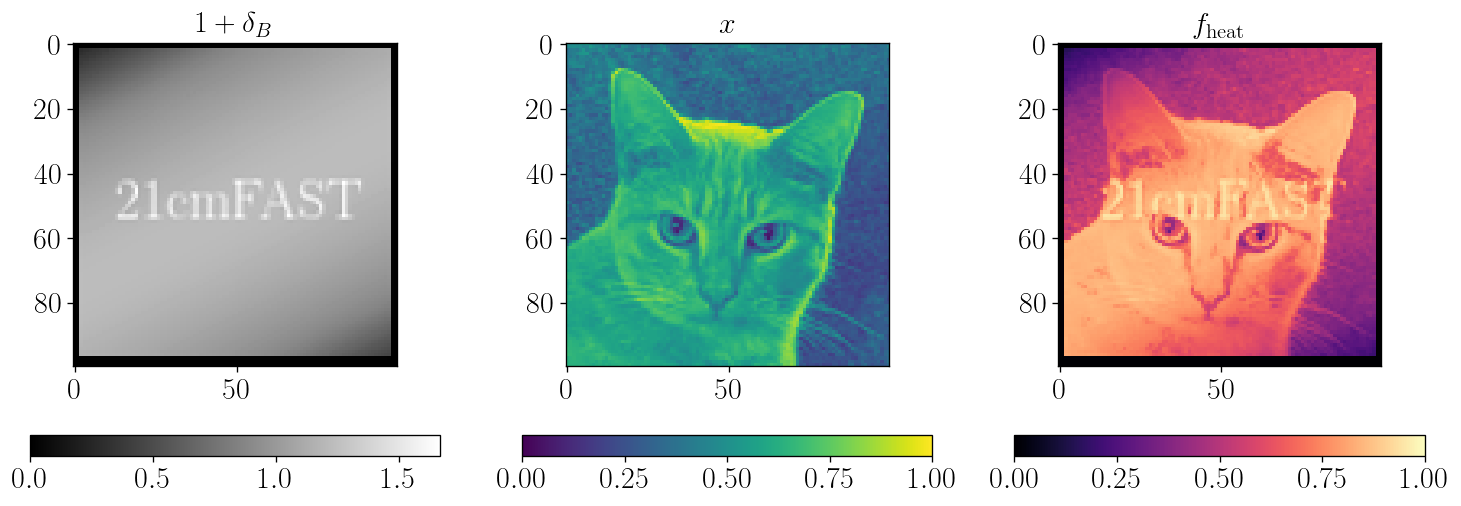

In [17]:
key = 'heat'

fig, axs = plt.subplots(1, 3, figsize=(15,5))
im0 = axs[0].imshow(nBs_box[0], cmap='binary_r')
im1 = axs[1].imshow(ionization_box[0], vmax=1, vmin=0)
im2 = axs[2].imshow(f_box[key][0], cmap='magma', vmax=1, vmin=0)
fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')
fig.colorbar(im2, ax=axs[2], orientation='horizontal')
axs[0].set(title=r'$1+\delta_B$')
axs[1].set(title=r'$x$')
axs[2].set(title=r'$f_\mathrm{%s}$' % key);

## A. Generate DM source image

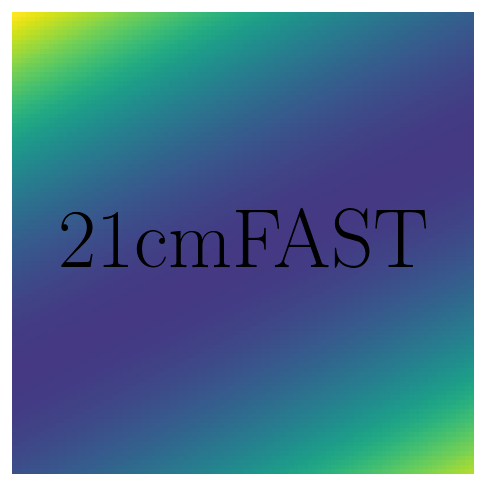

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
xs = np.linspace(0, 1, 100)
xs, ys = np.meshgrid(xs, xs)
ax.imshow(np.sin(xs+2*ys+np.pi), vmin=-1.2)
ax.text(10, 55, '21cmFAST', fontsize=50)
ax.set_aspect(1)
ax.axis('off')
plt.savefig('plots/source.png', dpi=25)